In [1]:
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import resize, rotate
from data_utils import pnt_on_grid, quant_rot, background_map, create_mask, display, get_pos_from_list_fp, list_from_fingerprint, get_conf_from_list_fp, list_from_rotation, get_conf_from_slice, get_rot_from_slice, corr_angle_rad, corr_angle_deg, zoom_in
import numpy as np
import pandas as pd
from data_mgmt import DAO
from data_generator import initialize_gen
import tensorflow as tf
from IPython.display import clear_output

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
from tensorflow.keras import layers, models, losses, backend, optimizers
#from tensorflow_addons.metrics import F1Score


1 Physical GPUs, 1 Logical GPUs


2022-07-29 14:28:40.773367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:28:40.892053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:28:40.892340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:28:40.901634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:28:40.901928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [2]:
original_map = io.imread("data/sanPiero.png")

original_map = original_map[:,:,0]
original_map = original_map / 255

with open("data/datasetmap90_line.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()[:360]

Model definition

In [3]:
def model_define_2(map_img, laser, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch_1 = layers.Conv2D(8, 11, padding="same", activation="relu", name="2_map_conv_1")(map_input)
    map_branch_2 = layers.Conv2D(16, 7, padding="same", activation="relu", name="2_map_conv_2")(map_branch_1)
    map_branch_3 = layers.MaxPool2D(5, strides=3, padding="same", name="2_map_pooling_1")(map_branch_2)
    map_branch_3 = layers.BatchNormalization()(map_branch_3)
    
    if training:
        map_branch_3 = layers.Dropout(0.5)(map_branch_3)
    else:
        map_branch_3 = layers.Dropout(0.0)(map_branch_3)
    
    map_branch_5 = layers.Conv2D(32, 7, padding="same", activation="relu", name="2_map_conv_3")(map_branch_3)
    map_branch_6 = layers.MaxPool2D(5, strides=3, padding="same", name="2_map_pooling_2")(map_branch_5)
    map_branch_6 = layers.BatchNormalization()(map_branch_6)
    
    if training:
        map_branch_6 = layers.Dropout(0.5)(map_branch_6)
    else:
        map_branch_6 = layers.Dropout(0.0)(map_branch_6)
    
    map_branch_8 = layers.Conv2D(64, 5, padding="same", activation="relu", name="2_map_conv_4")(map_branch_6)
    map_branch_9 = layers.MaxPool2D(3, strides=2, padding="same", name="2_map_pooling_3")(map_branch_8)
    map_branch_9 = layers.BatchNormalization()(map_branch_9)
    
    if training:
        map_branch_9 = layers.Dropout(0.5)(map_branch_9)
    else:
        map_branch_9 = layers.Dropout(0.0)(map_branch_9)
    
    map_branch_11 = layers.Conv2D(64, 5, padding="same", activation="relu", name="2_map_conv_5")(map_branch_9)
    map_branch_12 = layers.MaxPool2D(5, strides=3, padding="same", name="2_map_pooling_4")(map_branch_11)
    map_branch_12 = layers.BatchNormalization()(map_branch_12)

    if training:
        map_branch_12 = layers.Dropout(0.5)(map_branch_12)
    else:
        map_branch_12 = layers.Dropout(0.0)(map_branch_12)

    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(16, 11, padding="valid", activation="relu", name="2_laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(32, 7, padding="valid", activation="relu", name="2_laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(5, strides=3, padding="same", name="2_laser_pool_1" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.5)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)
    
    laser_branch = layers.Conv1D(64, kernel_size=5, padding="valid", activation="relu", name="2_laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="2_laser_pool_2" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.5)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    laser_branch = layers.Conv1D(128, kernel_size=5, padding="valid", activation="relu", name="2_laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="2_laser_pool_3" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    #merged_branch = layers.Concatenate()([map_branch_flat,laser_branch])

    if training:
        laser_branch = layers.Dropout(0.5)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    #in_model = models.Model([map_input,laser_input],merged_branch)

    #in_model.trainable = training

    laser_branch = layers.Dense((map_branch_12.shape[1]*map_branch_12.shape[2]*64), activation="relu", name="2_fc_merged")(laser_branch)
    laser_branch_reshape = layers.Reshape((map_branch_12.shape[1],map_branch_12.shape[2],64))(laser_branch)

    merged_branch_pos = layers.Concatenate()([map_branch_12,laser_branch_reshape])
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
       merged_branch_pos = layers.Dropout(0.7)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos_1 = layers.Conv2DTranspose(64,5,3, padding="same")(merged_branch_pos)

    #position branch
    
    diff_width = int(merged_branch_pos_1.shape[1] - map_branch_11.shape[1] + 1)
    diff_heigth = int(merged_branch_pos_1.shape[2] - map_branch_11.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(32,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos_1)

    else:
        merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos_1)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_11])
   
    merged_branch_pos = layers.Conv2DTranspose(32,5,2, padding="same")(merged_branch_pos) 

    if training:
       merged_branch_pos = layers.Dropout(0.7)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_8.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_8.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(16,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(16,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_8])

    merged_branch_pos = layers.Conv2DTranspose(16,7,3, padding="same")(merged_branch_pos) 
    
    if training:
        merged_branch_pos = layers.Dropout(0.7)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_5.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_5.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(8,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(8,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_5])

    merged_branch_pos = layers.Conv2DTranspose(8,7,3, padding="same")(merged_branch_pos) 

    if training:
        merged_branch_pos = layers.Dropout(0.7)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_2.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_2.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(4,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(4,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_2])

    merged_branch_pos = layers.Conv2DTranspose(2,11, padding="same", name="2_pos_output")(merged_branch_pos)

    return models.Model([map_input,laser_input],merged_branch_pos)

def recall_pos(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],y_pred.shape[2],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    all_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + backend.epsilon())
    return recall

def precision_pos(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],y_pred.shape[2],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_score_pos(y_true, y_pred):
    precision_value = precision_pos(y_true, y_pred)
    recall_value = recall_pos(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+backend.epsilon()))

def recall_rot(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    all_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + backend.epsilon())
    return recall

def precision_rot(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_score_rot(y_true, y_pred):
    precision_value = precision_rot(y_true, y_pred)
    recall_value = recall_rot(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+backend.epsilon()))


In [4]:
laser_inst=[]

for i in laser_db.values:
    if i[0] == 1:
        laser_inst.append(i[3])

laser_inst = tf.reshape(laser_inst, [360,1])

max_pixel = 10000
pixel_scale = 0.1
tot_pixel = original_map.shape[0]*original_map.shape[1]

if tot_pixel > max_pixel:
    rate_rescale = np.sqrt(max_pixel/tot_pixel) 
    
    #rate considerando che bisogna paddare la mappa
    #rate_rescale = np.sqrt(max_pixel/(np.power(original_map.shape[0],2)+np.power(original_map.shape[1],2)))

    new_height = int(original_map.shape[0] * rate_rescale)
    new_width = int(original_map.shape[1] * rate_rescale)
    
    map_img = resize(original_map,(new_height,new_width))

    #quad_side = int(np.sqrt(np.power(new_height,2)+np.power(new_width,2)))

    #left_pad = int((quad_side-new_width)/2)
    #top_pad = int((quad_side-new_height)/2)
    #map_img = np.pad(map_img,((top_pad,quad_side-top_pad-new_height),(left_pad,quad_side-left_pad-new_width)),"constant",constant_values=(0))

    pixel_scale = pixel_scale/rate_rescale

map_img_tensor = tf.reshape(map_img, [map_img.shape[0],map_img.shape[1],1])

batch_size = 1024

In [17]:
final_rate = np.sqrt(max_pixel/(np.power(rate_rescale,2)*(np.power(original_map.shape[0],2)+np.power(original_map.shape[1],2))))

In [13]:
model_2 = model_define_2(map_img_tensor,laser_inst)

In [6]:
model_2.load_weights("models/model_2_sp_zoom01cp-epoch-train.ckpt")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for models/model_2_sp_zoom01cp-epoch-train.ckpt

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

NameError: name 'model' is not defined

In [6]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 99, 99, 1)]  0           []                               
                                                                                                  
 2_map_conv_1 (Conv2D)          (None, 99, 99, 8)    976         ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 2_map_conv_2 (Conv2D)          (None, 99, 99, 16)   6288        ['2_map_conv_1[0][0]']           
                                                                                              

In [14]:
model_2.compile(optimizer = optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[f1_score_pos]    #["accuracy"]
    )

Data import

In [11]:
TR_gendata, TS_gendata = initialize_gen(DAO("datasetmap90_multirot_10k.csv"),map_img_tensor, pixel_scale, batch_size, (map_img_tensor.shape[0],map_img_tensor.shape[1],map_img_tensor.shape[2]))

In [7]:
data = DAO("datasetsanpiero_long_fp_path.csv")
data.read()
data.divide_data()

In [8]:
data.TR_features=tf.reshape(data.TR_features,[-1,360,1])
data.TS_features=tf.reshape(data.TS_features,[-1,360,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

In [24]:
dim_zoom = 0.2
pixel_zoom = 0.1/dim_zoom

x_real = data.TR_targets.numpy()[1][0]
y_real = data.TR_targets.numpy()[1][1]

sub_map,x,y = zoom_in(original_map, [y_real,x_real], new_width, new_height, dim_zoom)

sub_map = np.pad(sub_map,((top_pad,quad_side-top_pad-new_height),(left_pad,quad_side-left_pad-new_width)),"constant",constant_values=(0))

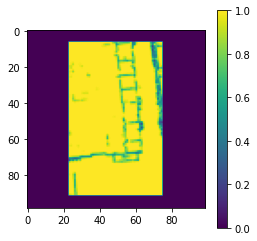

In [25]:
plt.figure(figsize=(4,4))
plt.imshow(sub_map)
plt.colorbar()
plt.grid(False)
plt.show()

In [31]:
x_pixel = x_real/pixel_zoom-(x)+left_pad
y_pixel = y_real/pixel_zoom-(y)+top_pad

In [32]:
mask = pnt_on_grid(sub_map, [x_pixel,y_pixel],10,1)

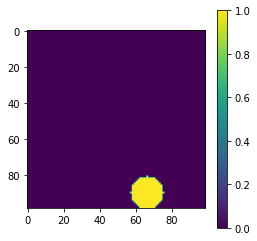

In [33]:
plt.figure(figsize=(4,4))
plt.imshow(mask)
plt.colorbar()
plt.grid(False)
plt.show()

In [34]:
map_rot = rotate(sub_map,-np.degrees(data.TR_targets.numpy()[1][2]))

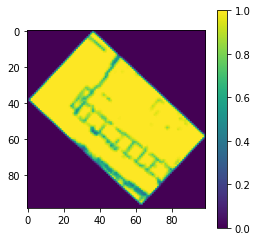

In [35]:
plt.figure(figsize=(4,4))
plt.imshow(map_rot)
plt.colorbar()
plt.grid(False)
plt.show()

In [127]:
center_sub_map_x = int((quad_side/2)*pixel_zoom)
center_sub_map_y = int((quad_side/2)*pixel_zoom)

In [128]:
center_mask = pnt_on_grid(sub_map, [center_sub_map_x,center_sub_map_y],10,pixel_zoom)

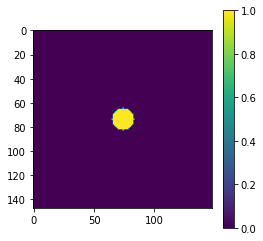

In [129]:
plt.figure(figsize=(4,4))
plt.imshow(center_mask)
plt.colorbar()
plt.grid(False)
plt.show()

In [36]:
alpha = -data.TR_targets.numpy()[1][2]
rot_mat = np.matrix([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])

In [37]:
pos_rot = np.matmul(rot_mat,[x_pixel-center_sub_map_x/pixel_zoom,y_pixel-center_sub_map_y/pixel_zoom])

pos_rot += [center_sub_map_x/pixel_zoom,center_sub_map_y/pixel_zoom]

#pos_rot *= pixel_zoom

In [180]:
center_dist_1 = [[np.abs(x_pixel-center_sub_map_x/pixel_zoom)],[np.abs(y_pixel-center_sub_map_y/pixel_zoom)]]
center_dist_2 = np.abs(pos_rot-center_sub_map_x/pixel_zoom)

In [38]:
pos_rot_mask = pnt_on_grid(sub_map, [int(pos_rot.tolist()[0][0]),int(pos_rot.tolist()[0][1])],10,1)

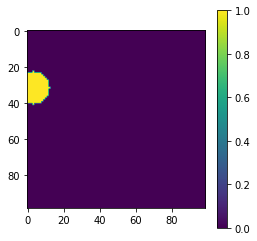

In [39]:
plt.figure(figsize=(4,4))
plt.imshow(pos_rot_mask)
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
#dataset sub-map padded and rotate

TR_map=[]
TR_masks=[]
TS_map=[]
TS_masks=[]

TR_temp = data.TR_targets.numpy().copy()
TS_temp = data.TS_targets.numpy().copy()

dim_zoom = 0.1
pixel_zoom = 0.1/dim_zoom

center_sub_map_x = int((quad_side/2)*pixel_zoom)
center_sub_map_y = int((quad_side/2)*pixel_zoom)

for i in range(data.TR_features.shape[0]):
    x_real = TR_temp[i][0]
    y_real = TR_temp[i][1]
    
    sub_map, x_0, y_0 = zoom_in(original_map, [y_real,x_real], new_width, new_height, dim_zoom)

    sub_map = np.pad(sub_map,((top_pad,quad_side-top_pad-new_height),(left_pad,quad_side-left_pad-new_width)),"constant",constant_values=(0))
    
    x_pixel = x_real*pixel_zoom-(x_0)+left_pad
    y_pixel = y_real*pixel_zoom-(y_0)+top_pad
    
    sub_map = rotate(sub_map,-np.degrees(data.TR_targets.numpy()[i][2]))

    TR_map.append(sub_map)

    alpha = -TR_temp[i][2]
    rot_mat = np.matrix([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])

    pos_rot = np.matmul(rot_mat,[x_pixel-center_sub_map_x/pixel_zoom,y_pixel-center_sub_map_y/pixel_zoom])
    pos_rot += [center_sub_map_x/pixel_zoom,center_sub_map_y/pixel_zoom]

    map_grid_inst = pnt_on_grid(sub_map, [int(pos_rot.tolist()[0][0]),int(pos_rot.tolist()[0][1])],10,1)
    TR_masks.append(map_grid_inst)

for i in range(data.TS_features.shape[0]):
    x_real = TS_temp[i][0]
    y_real = TS_temp[i][1]
    
    sub_map, x_0, y_0 = zoom_in(original_map, [y_real,x_real], new_width, new_height, dim_zoom)

    sub_map = np.pad(sub_map,((top_pad,quad_side-top_pad-new_height),(left_pad,quad_side-left_pad-new_width)),"constant",constant_values=(0))
    
    x_pixel = x_real*pixel_zoom-(x_0)+left_pad
    y_pixel = y_real*pixel_zoom-(y_0)+top_pad
    
    sub_map = rotate(sub_map,-np.degrees(data.TS_targets.numpy()[i][2]))

    TS_map.append(sub_map)

    alpha = -TS_temp[i][2]
    rot_mat = np.matrix([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])

    pos_rot = np.matmul(rot_mat,[x_pixel-center_sub_map_x/pixel_zoom,y_pixel-center_sub_map_y/pixel_zoom])
    pos_rot += [center_sub_map_x/pixel_zoom,center_sub_map_y/pixel_zoom]

    map_grid_inst = pnt_on_grid(sub_map, [int(pos_rot.tolist()[0][0]),int(pos_rot.tolist()[0][1])],10,1)
    TS_masks.append(map_grid_inst)


In [9]:
#dataset sub_map

TR_map=[]
TR_masks=[]
TS_map=[]
TS_masks=[]

TR_origin_map =[]
TS_origin_map =[]

TR_temp = data.TR_targets.numpy().copy()
TS_temp = data.TS_targets.numpy().copy()

dim_zoom = 0.1
pixel_zoom = 0.1/dim_zoom

for i in range(data.TR_features.shape[0]):
    x_real = TR_temp[i][0]
    y_real = TR_temp[i][1]
    
    sub_map, x_0, y_0 = zoom_in(original_map, [y_real,x_real], new_width, new_height, dim_zoom)
    
    x_pixel = x_real/pixel_zoom-(x_0)
    y_pixel = y_real/pixel_zoom-(y_0)

    TR_map.append(sub_map)
    TR_origin_map.append([x_0,y_0])

    map_grid_inst = pnt_on_grid(sub_map, [x_pixel,y_pixel],10,1)

    TR_masks.append(map_grid_inst)

for i in range(data.TS_features.shape[0]):
    x_real = TS_temp[i][0]
    y_real = TS_temp[i][1]
    
    sub_map, x_0, y_0 = zoom_in(original_map, [y_real,x_real], new_width, new_height, dim_zoom)

    x_pixel = x_real/pixel_zoom-(x_0)
    y_pixel = y_real/pixel_zoom-(y_0)

    TS_map.append(sub_map)
    TS_origin_map.append([x_0,y_0])

    map_grid_inst = pnt_on_grid(sub_map, [x_pixel,y_pixel],10,1)

    TS_masks.append(map_grid_inst)


In [10]:
TR_map = tf.reshape(TR_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_map = tf.reshape(TS_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

2022-07-29 14:58:51.815685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 297180000 exceeds 10% of free system memory.
2022-07-29 14:58:56.139794: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 297180000 exceeds 10% of free system memory.


[122.6        80.9         4.9043752]


2022-07-20 11:45:47.553658: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 297180000 exceeds 10% of free system memory.


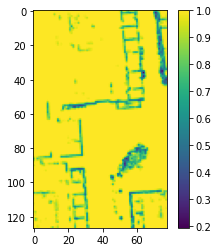

2022-07-20 11:45:48.148008: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 297180000 exceeds 10% of free system memory.


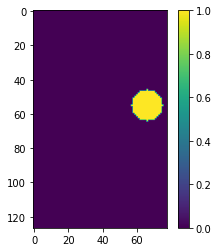

In [11]:
num = 100
print(TR_temp[num])

plt.figure(figsize=(4,4))
plt.imshow(TR_map.numpy()[num])
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(TR_masks.numpy()[num])
plt.colorbar()
plt.grid(False)
plt.show()

In [11]:
#position grid

TR_masks = []

for i in data.TR_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img, i,15,pixel_scale)
    TR_masks.append(map_grid_inst)

TS_masks = []

for i in data.TS_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img, i,15,pixel_scale)
    TS_masks.append(map_grid_inst)


In [24]:
with open('data/temp/TR_masks.csv', 'w') as f:
    cnt=1

    for map_grid_inst in TR_masks:
        
        n_item = 0

        f.write("{};".format(cnt))
        for row in map_grid_inst:
            for item in row:
                if n_item == len(row)*len(map_grid_inst)-1:
                    f.write("{}".format(item))                 
                else:
                    f.write("{};".format(item))
                n_item += 1
        
        cnt += 1
        f.write("\n")

with open('data/temp/TS_masks.csv', 'w') as f:
    cnt=1

    for map_grid_inst in TS_masks:
        
        n_item = 0

        f.write("{};".format(cnt))
        for row in map_grid_inst:
            for item in row:
                if n_item == len(row)*len(map_grid_inst)-1:
                    f.write("{}".format(item))                 
                else:
                    f.write("{};".format(item))
                n_item += 1
        
        cnt += 1
        f.write("\n")

In [25]:
with open('data/temp/TR_mask_rot.csv', 'w') as f:
    cnt=1

    for rot_grid_inst in TR_masks_rot:
        
        n_item = 0

        f.write("{};".format(cnt))
        for item in rot_grid_inst:
        
            if n_item == len(rot_grid_inst)-1:
                f.write("{}".format(item))                 
            else:
                f.write("{};".format(item))
            n_item += 1
        
        cnt += 1
        f.write("\n")

with open('data/temp/TS_mask_rot.csv', 'w') as f:
    cnt=1

    for rot_grid_inst in TS_masks_rot:
        
        n_item = 0

        f.write("{};".format(cnt))
        for item in rot_grid_inst:
        
            if n_item == len(rot_grid_inst)-1:
                f.write("{}".format(item))                 
            else:
                f.write("{};".format(item))
            n_item += 1
        
        cnt += 1
        f.write("\n")

In [10]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_multirot2_gridpos_r7.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

if len(masks.values) > 3600:
    masks = masks.head(3601)

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

with open("data/datasetmymap_multirot2_gridrot_r3_q90.csv", "r") as file:
    laser_db_mask_rot = pd.read_csv(file, delimiter=";",header=None).copy()

masks_rot = laser_db_mask_rot.drop(columns=[0])

if len(masks_rot.values) > 3600:
    masks_rot = masks_rot.head(3601)

TR_x, TS_x, TR_masks_rot, TS_masks_rot = train_test_split(data.features, masks_rot, test_size= 0.25, random_state= 42)

In [ ]:
with open("data/temp/TR_masks.csv", "r") as file:
    TR_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_masks.csv", "r") as file:
    TS_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TR_mask_rot.csv", "r") as file:
    TR_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_mask_rot.csv", "r") as file:
    TS_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

TR_masks = TR_masks.drop(columns=[0])
TS_masks = TS_masks.drop(columns=[0])
TR_masks_rot = TR_masks_rot.drop(columns=[0])
TS_masks_rot = TS_masks_rot.drop(columns=[0])


In [12]:
TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

2022-06-28 18:07:37.602855: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 303613200 exceeds 10% of free system memory.


Model Training

In [23]:
test_map = TS_map[0]
#test_x = TS_x.values[0]
test_x = data.TS_features.numpy()[0]

test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
test_x = tf.reshape(test_x,[1,360])

pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
sample = create_mask(pred_test_pos)
sample_rot = create_mask(pred_test_rot)

#pred_test = model.predict([test_map,test_x])
#sample = create_mask(pred_test)

sample_targets = data.TS_targets_pos[0]

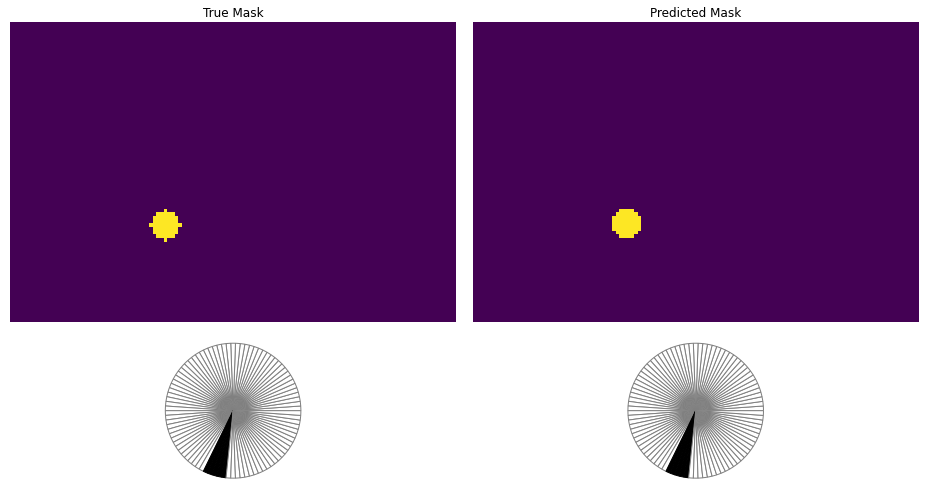

In [43]:
display([TS_masks[0],sample],[TS_masks_rot[0],sample_rot])

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
    min_loss=0

    #test_x = data.TS_features[0]
    #TS_pos = data.TS_targets_pos[0].numpy()
    #TS_rot = data.TS_targets_rot[0].numpy()[0]

    #test_map = tf.reshape(map_img_tensor,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    #test_x = tf.reshape(test_x,[1,360])

    def on_epoch_end(self, epoch, logs=False):
        
        met_value = (logs["val_f1_score_pos"])/5 - np.log10((logs["val_loss"]*5))

        if met_value >self.min_loss and logs["val_loss"] < logs["loss"]:
            model_2.save_weights("models/cp-epoch-train.ckpt")
            self.min_loss = met_value
        
        #if epoch % 5 == 4:
            clear_output(wait=True)
            print(met_value)
            #pred_output = model.predict([self.test_map,self.test_x])
            #display([pnt_on_grid(map_img_tensor, self.TS_pos,7,pixel_scale),create_mask(pred_output[0])],[quant_rot(self.TS_rot,90,3),create_mask(pred_output[1])])#)])

my_callback= MyCallback()

In [17]:
history = model_2.fit([TR_map,data.TR_features],
    TR_masks, 
    validation_data=([TS_map,data.TS_features],[TS_masks]), 
    verbose=1,
    batch_size=16,
    epochs=50,
    callbacks=[my_callback]
    )

Epoch 1/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0202 - f1_score_pos: 0.8276 - val_loss: 0.0189 - val_f1_score_pos: 0.8492
Epoch 2/50
235/235 [==============================] - 18s 76ms/step - loss: 0.0203 - f1_score_pos: 0.8261 - val_loss: 0.0211 - val_f1_score_pos: 0.8278
Epoch 3/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0204 - f1_score_pos: 0.8252 - val_loss: 0.0191 - val_f1_score_pos: 0.8466
Epoch 4/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0201 - f1_score_pos: 0.8277 - val_loss: 0.0190 - val_f1_score_pos: 0.8453
Epoch 5/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0203 - f1_score_pos: 0.8268 - val_loss: 0.0186 - val_f1_score_pos: 0.8514
Epoch 6/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0202 - f1_score_pos: 0.8266 - val_loss: 0.0191 - val_f1_score_pos: 0.8498
Epoch 7/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0202 - f1_

In [11]:
history = model_1.fit(TR_gendata,
    validation_data=TS_gendata,
    batch_size=batch_size,
    epochs=130,
    callbacks=[my_callback]
    )

RuntimeError: in user code:

    File "/tmp/ipykernel_1965/267663073.py", line 7, in fit  *
        callbacks=[my_callback]
    File "/home/ait_guest/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/ait_guest/.local/lib/python3.9/site-packages/keras/engine/training.py", line 3266, in _disallow_inside_tf_function
        raise RuntimeError(error_msg)

    RuntimeError: Detected a call to `Model.fit` inside a `tf.function`. `Model.fit is a high-level endpoint that manages its own `tf.function`. Please move the call to `Model.fit` outside of all enclosing `tf.function`s. Note that you can call a `Model` directly on `Tensor`s inside a `tf.function` like: `model(x)`.


In [32]:
def loss(model, input, target, training=True):
  pred = model(input)
  pos_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(target[0],pred[0])
  rot_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(target[1],pred[1])
  return pos_loss + rot_loss

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = optimizers.Adam()

def train_phase_1(model, map, original_map, laser_batch):

  map_array = []

  map = tf.reshape(map,[1,map.shape[0],map.shape[1],map.shape[2]])

  for laser in laser_batch:
    laser = tf.reshape(laser, [1,laser.shape[0],laser.shape[1]])

    model_output = model.predict([map, laser])

    output_fp = list_from_fingerprint(model_output[0][0], pixel_scale)

    if len(output_fp) == 0:
      map_zoomed = np.zeros((map.shape[1],map.shape[2]))

    else:
      pos_output = get_pos_from_list_fp(output_fp)
      map_zoomed = zoom_in(original_map, pos_output, max_pixel)

    print(pos_output)
    plt.figure(figsize=(6,6))
    plt.imshow(map_zoomed)
    plt.colorbar()
    plt.grid(False)
    plt.show()

    map_array.append(map_zoomed)

  map_array = tf.reshape(map_array,[laser_batch.shape[0],map.shape[1],map.shape[2],map.shape[3]])

  return [map_array, laser_batch]


In [ ]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting

def train_step(model_1, model_2, TR_gendata, TS_gendata, num_epochs, batch, map_img_tensor, original_map):

  train_loss_results = []
  train_f1_pos_results = []

  val_loss_results = []
  val_f1_pos_results = []

  min_loss = 0

  num_epochs = num_epochs
  real_batch = batch

  for epoch in range(num_epochs):
    print("Epoch {:03d}".format(epoch))

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_f1_pos = []

    epoch_loss_avg_val = tf.keras.metrics.Mean()
    epoch_f1_pos_val = []

    # Training loop - using batches of 32
    for x, y in TR_gendata:
      # Optimize the model
      for i in range(int(x.shape[0]/real_batch)):
        x_0= tf.reshape(x[i*real_batch:(i+1)*real_batch],[real_batch,x.shape[1],x.shape[2]])
        model_2_input = train_phase_1(model_1, map_img_tensor, original_map, x_0)
        x_ = model_2_input

        y_0= tf.reshape(y[0][i*real_batch:(i+1)*real_batch],[real_batch,y[0][i].shape[0],y[0][i].shape[1],y[0][i].shape[2]])
        y_= y_0

        loss_value, grads = grad(model_2, x_, y_)
        optimizer.apply_gradients(zip(grads, model_2.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_f1_pos.append(f1_score_pos(y_, model_2(x_, training=True)))

    train_loss_results.append(epoch_loss_avg.result())
    train_f1_pos_results.append(np.average(epoch_f1_pos))
    
    print("Loss: {:.5f}, F1 score: {:.4} ".format(epoch_loss_avg.result(),
                                                np.average(epoch_f1_pos)
                                                ))

    #Validation
    
    #if epoch % 2 == 0:

    for x, y in TS_gendata:
      # Optimize the model
      for i in range(int(x.shape[0]/real_batch)):
        x_0= tf.reshape(x[i*real_batch:(i+1)*real_batch],[real_batch,x.shape[1],x.shape[2]])
        model_2_input = train_phase_1(model_1, map_img_tensor, original_map, x_0)
        x_ = model_2_input
        
        y_0= tf.reshape(y[0][i*real_batch:(i+1)*real_batch],[real_batch,y[0][i].shape[0],y[0][i].shape[1],y[0][i].shape[2]])
        y_= y_0
        loss_value, grads = grad(model_2, x_, y_)

        # Track progress
        epoch_loss_avg_val.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_f1_pos_val.append(f1_score_pos(y_, model_2(x_, training=False)))
      
    val_loss_results.append(epoch_loss_avg_val.result())
    val_f1_pos_results.append(np.average(epoch_f1_pos_val))
    
    #print(np.average(epoch_f1_pos_val))
    #print(np.average(epoch_f1_pos_val))
    #print(epoch_loss_avg_val.result())

    met_value = np.average(epoch_f1_pos_val)/5 - np.log10((epoch_loss_avg_val.result()*5))

    if met_value > min_loss:
        model.save_weights("models/cp-epoch-train.ckpt")
        min_loss = met_value

        clear_output(wait=True)

        print("Val Loss: {:.5f}, Val F1 score: {:.4} , Met: {}".format(epoch_loss_avg_val.result(),
                                                            np.average(epoch_f1_pos_val),
                                                            met_value
                                                            ))

train_step(model_1, model_2, TR_gendata, TS_gendata, 2, 64, map_img_tensor,original_map)


Evaluation best model

In [12]:
data = DAO("laser_log2203w_mod90.csv")
data.read()
data.divide_data()

data.TR_features=tf.reshape(data.TR_features,[-1,360,1])
data.TS_features=tf.reshape(data.TS_features,[-1,360,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

data.TR_targets_pos=tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos=tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot=tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot=tf.gather(data.TS_targets,[2],axis=1)

TR_map=[]
TS_map=[]

for i in range(data.TR_features.shape[0]):
    TR_map.append(map_img_tensor)

for i in range(data.TS_features.shape[0]):
    TS_map.append(map_img_tensor)

TR_map = tf.reshape(TR_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])
TS_map = tf.reshape(TS_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])

In [ ]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_test_gridpos_r5.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

if len(masks.values) > 3600:
    masks = masks.head(3601)

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

with open("data/datasetmymap_test_gridrot_r3_q90.csv", "r") as file:
    laser_db_mask_rot = pd.read_csv(file, delimiter=";",header=None).copy()

masks_rot = laser_db_mask_rot.drop(columns=[0])

if len(masks_rot.values) > 3600:
    masks_rot = masks_rot.head(3601)

TR_x, TS_x, TR_masks_rot, TS_masks_rot = train_test_split(data.features, masks_rot, test_size= 0.25, random_state= 42)

TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

In [13]:
with open("data/temp/TR_masks.csv", "r") as file:
    TR_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_masks.csv", "r") as file:
    TS_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TR_mask_rot.csv", "r") as file:
    TR_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_mask_rot.csv", "r") as file:
    TS_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

TR_masks = TR_masks.drop(columns=[0])
TS_masks = TS_masks.drop(columns=[0])
TR_masks_rot = TR_masks_rot.drop(columns=[0])
TS_masks_rot = TS_masks_rot.drop(columns=[0])

TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

In [90]:
model = model_define(map_img_tensor, laser_inst, 90)

model.load_weights("models/cp-epoch-train.ckpt")

model.compile(optimizer = "adam",
    loss=[losses.SparseCategoricalCrossentropy(from_logits=True),losses.SparseCategoricalCrossentropy(from_logits=True)],#losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[[f1_score_pos],[f1_score_rot]]    #["accuracy"]
    )

In [14]:
model.evaluate([TR_map,data.TR_features],
    [TR_masks, TR_masks_rot],
    batch_size=1)

827/827 [==============================] - 13s 12ms/step - loss: 0.1116 - pos_output_loss: 0.0289 - rot_output_loss: 0.0826 - pos_output_f1_score_pos: 0.2319 - rot_output_f1_score_rot: 0.7360


[0.1115712970495224,
 0.028931692242622375,
 0.08263955265283585,
 0.23187828063964844,
 0.7360177040100098]

Create image list

In [18]:
data = DAO("datasetsanpiero_path.csv")
data.read()

data.features=tf.reshape(data.features,[-1,360,1])
data.targets=tf.reshape(data.targets,[-1,3])

data.TS_targets_pos=tf.gather(data.targets,[0,1],axis=1)
data.TS_targets_rot=tf.gather(data.targets,[2],axis=1)

map_input=[]
masks=[]
pos_sub_map = []

temp = data.TS_targets_pos.numpy().copy()

dim_zoom = 0.15#np.sqrt(rate_rescale)
pixel_zoom = 0.1/dim_zoom

for i in range(data.features.shape[0]):
    x_real = temp[i][0]
    y_real = temp[i][1]
    
    sub_map, x_0, y_0 = zoom_in(original_map, [y_real,x_real], new_width, new_height, dim_zoom)
    
    x_pixel = x_real/pixel_zoom-(x_0)
    y_pixel = y_real/pixel_zoom-(y_0)

    map_input.append(sub_map)

    map_grid_inst = pnt_on_grid(sub_map, [x_pixel,y_pixel],10,1)

    masks.append(map_grid_inst)
    pos_sub_map.append([x_pixel, y_pixel])

pos_masks = tf.reshape(masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

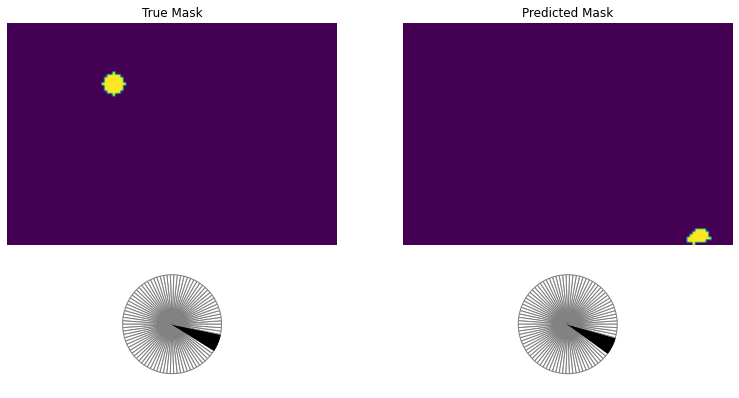

130


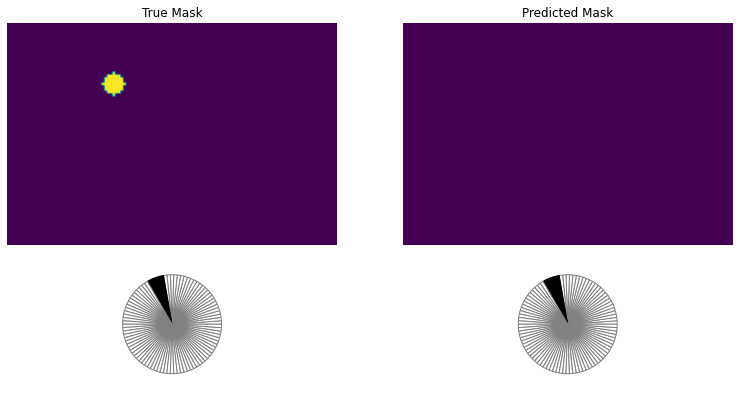

131


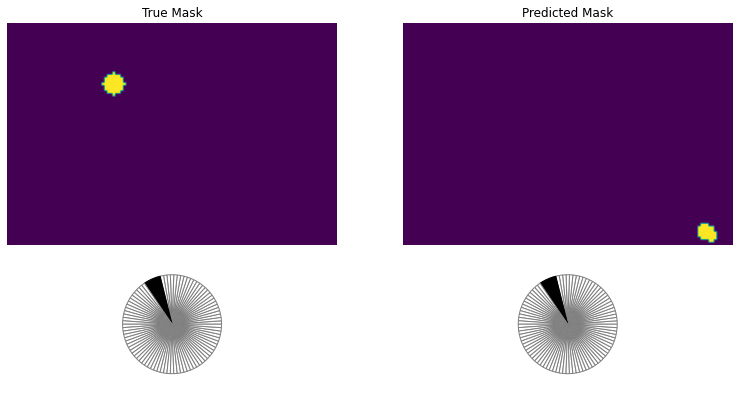

132


In [39]:
for index in range(len(map_masks)):

    test_map = map_masks[index]
    test_x = data.features.numpy()[index]


    test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    test_x = tf.reshape(test_x,[1,360])

    pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
    sample = create_mask(pred_test_pos)
    sample_rot = create_mask(pred_test_rot)

    #sample = background_map(sample, map_img)
    #sample = tf.reshape(sample,[map_img_tensor.shape[0],map_img_tensor.shape[1],1])

    clear_output(wait=True)

    display([pos_masks[index],sample],[rot_masks[index],sample_rot],"inst_{}".format(index))

    print(index)
    

In [19]:
#error centroids pos

error_list = []
conf_list = []

for index in range(len(map_input)):

    test_map = map_input[index]
    test_x = data.features.numpy()[index]

    test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    test_x = tf.reshape(test_x,[1,360])

    pred_test_pos = model_2.predict([test_map,test_x])
    pred_test_pos = tf.reshape(pred_test_pos,[pred_test_pos.shape[1],pred_test_pos.shape[2],2])

    list_fp_pred = list_from_fingerprint(pred_test_pos,pixel_zoom)

    if len(list_fp_pred) > 0:

        centroid_pred = get_pos_from_list_fp(list_fp_pred)
        x_zoom = pos_sub_map[index][0]*pixel_zoom
        y_zoom = pos_sub_map[index][1]*pixel_zoom
        error = np.sqrt(np.power((x_zoom-centroid_pred[0]),2)+np.power((y_zoom-centroid_pred[1]),2))
        conf = get_conf_from_list_fp(list_fp_pred)

    else:
        error = -1
        conf = 0

    error_list.append(error)
    conf_list.append(conf)

    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
with open('metrics/error_conf_sanpiero_model2_tris.csv', 'w') as f:
    for i in range(len(error_list)):
        f.write("{};{};{}\n".format(i,error_list[i],conf_list[i]))

In [22]:
with open("metrics/error_conf_sanpiero_model2_tris.csv", "r") as file:
    gen = pd.read_csv(file, delimiter=";",header=None).copy()

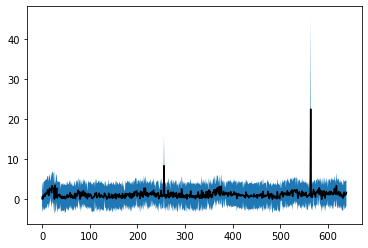

In [23]:
x_gen = gen[0] 
y_gen = gen[1]
error_gen = gen[2]

plt.plot(x_gen, y_gen, 'k-')
plt.fill_between(x_gen, y_gen-error_gen, y_gen+error_gen)

plt.show()


In [24]:
np.average(y_gen)

1.2374842115119218

In [30]:
np.std(y_gen)

0.5286064491056212

Multi direction

In [8]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result[0]
    rot_test = result[1][:,0]
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T
    rot_real = data_eval.TS_targets_rot.numpy()[:,0]

    return pos_test, rot_test, pos_real, rot_real

In [9]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [8]:
#data_eval, map_eval = get_data("laser_log2203.csv",map_img)

#pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

#with open('predict_data2203.csv', 'w') as f:
#    for i in range(len(pos_real)):
#        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


data_eval, map_eval = get_data("laser_log2303.csv",map_img_tensor)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-26 15:31:45.620114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-26 15:31:46.451828: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 822.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [10]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64).csv",map_img_tensor)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap(3-123,60-64).csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-27 16:30:45.977861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Uni direction

In [6]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T

    return pos_test, pos_real

In [7]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [16]:
data_eval, map_eval = get_data("laser_log2303_unidir.csv",map_img_tensor)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303_unidir.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))

KeyboardInterrupt: 

In [8]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64)_unidir.csv",map_img_tensor)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))


2022-05-02 16:23:57.652676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
